The workflow of this notebook involves several steps to process ultrasound volume data and mesh files, ultimately preparing them for training a machine learning model. Here's a step-by-step breakdown:

1. **Environment Setup**: The necessary Python packages are installed, including `numpy`, `SimpleITK`, `plyfile`, `scipy`, and `opencv-python`.

2. **MHD File Creation**: A `.mhd` metadata file is created for a given `.raw` volume file. This file contains metadata about the volume, such as dimensions, element spacing, and data type.

3. **Volume Loading**: The ultrasound volume is loaded from the `.mhd` file using SimpleITK. The volume is a 3D numpy array with dimensions (1280, 768, 768) and data type `uint16`.

4. **Volume Preprocessing**: The loaded volume is resized from 768x768 to 256x256 per slice using `scipy.ndimage.zoom`. The values are normalized to a range of 0 to 1 and converted to `float32`.

5. **Mesh Loading**: A PLY mesh file is loaded, extracting vertices and faces. The mesh contains 38402 vertices and 75917 faces.

6. **Mesh to Masks Conversion**: The 3D vertices from the mesh are converted into 2D binary masks. The masks are dilated and resized to match the preprocessed volume size (256x256 per slice).

7. **Data Augmentation**: A copy of each slice is then rotated and saved to serve as another training pair.

8. **Training Data Information**: The shapes and value ranges of the input slices and target masks are printed, along with an example of a training pair.  


This workflow prepares the data for training a machine learning model by converting raw ultrasound data and mesh files into a format suitable for model input and target output.

In [1]:
!pip install numpy SimpleITK plyfile scipy opencv-python 
!apt-get update
!apt-get install -y xvfb libgl1-mesa-glx
# Example volume ID; used throughout the notebook
volume_id = 5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 30.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Get:1 http://deb.debian.org/debian bullseye InRelease [116 kB]
Get:2 http://deb.debian.org/debian-security bullseye-security InRelease [27.2 kB]
Get:3 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]
Get:4 http://deb.debian.org/debian bullseye/main amd64 Packages [8,066 kB]
Get:5 http://deb.debian.org/debian-security bullseye-security/main amd64 Packages [308 kB]
Get:6 http://deb.debian.org/debian bullseye-updates/main amd64 Packages [18.8 kB]
Fetched 8,580 kB in 1s (7,252 kB/s)




The following additional packages will be installed:
  libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libdrm2 libfontenc1 libgl1 libgl1-mesa-dri libglapi-mesa libglvnd0
  libglx-mesa0 libglx0

In [2]:
# create mhd file for a single raw file
def create_mhd_file(str):  # Updated path
    """
    Create a .mhd metadata file for a given .raw volume file
    """
    mhd_content = f"""ObjectType = Image
        NDims = 3
        BinaryData = True
        BinaryDataByteOrderMSB = False
        CompressedData = False
        TransformMatrix = 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0
        Offset = 0.0 0.0 0.0
        CenterOfRotation = 0.0 0.0 0.0
        AnatomicalOrientation = RAI
        ElementSpacing = 0.49479 0.49479 0.3125
        DimSize = 768 768 1280
        ElementType = MET_USHORT
        ElementDataFile = {str}"""  # This now includes the train_raw directory
    
    with open(f"scan_{volume_id:03}.mhd", 'w') as f:
        f.write(mhd_content)
    print(f"Created scan_{volume_id:03}.mhd with updated path to raw file")

# Create the .mhd file
create_mhd_file(f"raw_files/scan_{volume_id:03}.raw")



Created scan_005.mhd with updated path to raw file


In [3]:
# Loading the volume (raw file) through the generated mhd file above
# right now just loading a single file (scan_001)
import SimpleITK as sitk
import numpy as np

def load_volume(volume_id: int) -> np.ndarray:
    """
    Load a single ultrasound volume from .mhd file
    Args:
        volume_id: ID number of the volume to load (1-5 for labeled data)
    Returns:
        3D numpy array containing ultrasound data
    """
    filename = f"scan_{volume_id:03d}.mhd"
    
    try:
        # Read the .mhd file using SimpleITK
        header = sitk.ReadImage(filename)
        
        # Convert SimpleITK image to numpy array
        volume = sitk.GetArrayFromImage(header)
        
        # Print volume shape and info to verify dimensions
        print(f"Loaded volume shape: {volume.shape}")
        print(f"Data type: {volume.dtype}")
        print(f"Value range: [{volume.min()}, {volume.max()}]")
        
        return volume
        
    except Exception as e:
        print(f"Error loading volume: {e}")
        return None

# 1280 slices, each 768*768 picels
# current value range 0-38685, we need to normalize to 0-1
volume_data = load_volume(volume_id)

Loaded volume shape: (1280, 768, 768)
Data type: uint16
Value range: [0, 36753]


In [4]:
# Resized each slice from 768*768 to 256*256 because raw file too big (what they did in the report)
# Converted to float32 and normalized value range to 0-1

import numpy as np
from scipy.ndimage import zoom


def preprocess_volume(volume: np.ndarray, target_size: tuple = (256, 256)) -> np.ndarray:
    
    """
    Preprocess the volume by downsampling and normalizing using scipy
    Args:
        volume: Input volume of shape (1280, 768, 768)
        target_size: Desired size for each slice (width, height)
    Returns:
        Preprocessed volume
    """

    # Calculate zoom factors
    zoom_factors = (1,  # Don't change number of slices
                   target_size[0] / volume.shape[1],  # height scale
                   target_size[1] / volume.shape[2])  # width scale
    
    print("Resizing volume...")
    # Resize the volume using scipy zoom
    processed_volume = zoom(volume, zoom_factors, order=1)
    
    print("Normalizing values...")
    # Normalize to [0,1]
    processed_volume = processed_volume.astype(np.float32)  # Convert to float32 first
    processed_volume = (processed_volume - processed_volume.min()) / (processed_volume.max() - processed_volume.min())
    
    # Print info about processed volume
    print(f"Processed volume shape: {processed_volume.shape}")
    print(f"Processed data type: {processed_volume.dtype}")
    print(f"Processed value range: [{processed_volume.min()}, {processed_volume.max()}]")
    
    return processed_volume


# Example usage:
if __name__ == "__main__":
    # Assuming we have loaded volume_data from previous step
    processed_volume = preprocess_volume(volume_data)

Resizing volume...
Normalizing values...
Processed volume shape: (1280, 256, 256)
Processed data type: float32
Processed value range: [0.0, 1.0]


In [5]:
# Now we load a single mesh file
# Number of vertices: 38402
# Number of faces: 75917

from plyfile import PlyData
import numpy as np

def load_mesh(volume_id: int, mesh_dir: str = 'train_mesh') -> tuple:
    """
    Load a PLY mesh file and extract vertices and faces
    Args:
        volume_id: ID number of the volume (1-5 for labeled data)
        mesh_dir: Directory containing the mesh files
    Returns:
        Tuple of (vertices, faces)
    """
    filename = f"{mesh_dir}/scan_{volume_id:03d}.ply"
    
    
    try:
        # Load PLY file
        plydata = PlyData.read(filename)
        
        # Extract vertices
        vertices = np.vstack([
            plydata['vertex']['x'],
            plydata['vertex']['y'],
            plydata['vertex']['z']
        ]).T
        
        # Extract faces if they exist
        if 'face' in plydata:
            faces = np.array([face[0] for face in plydata['face']])
        else:
            faces = None
        
        # Print information about the mesh
        print(f"Loaded mesh from {filename}")
        print(f"Number of vertices: {vertices.shape[0]}")
        if faces is not None:
            print(f"Number of faces: {len(faces)}")
        
        return vertices, faces
        

    except Exception as e:
        print(f"Error loading mesh: {e}")
        return None, None

# Try loading the mesh for volume 1
vertices, faces = load_mesh(volume_id)

Loaded mesh from train_mesh/scan_005.ply
Number of vertices: 121887
Number of faces: 240661


In [6]:
# now we convert the 3D vertices into 2D binary masks and dilate


import numpy as np
from scipy import ndimage


def convert_mesh_to_masks(vertices: np.ndarray, 
                         volume_shape: tuple,
                         spacing: tuple = (0.49479, 0.49479, 0.3125),
                         target_size: tuple = (256, 256)) -> np.ndarray:
                         
    """
    Convert mesh vertices to binary masks
    Args:
        vertices: Mesh vertices array from PLY file
        volume_shape: Shape of the original volume (1280, 768, 768)
        spacing: Spacing between points in the original volume
        target_size: Size of target masks (matches preprocessed volume)
    Returns:
        Binary masks array
    """

    # Create empty mask volume at original size
    print("Creating initial masks...")
    masks = np.zeros(volume_shape, dtype=np.float32)
    
    # Scale vertices to voxel coordinates
    # Adjusting scale based on spacing provided
    voxel_coords = np.round(vertices / spacing).astype(int)
    
    # Filter valid coordinates
    print("Converting vertices to voxel coordinates...")
    valid_coords = np.all((voxel_coords >= 0) & 
                         (voxel_coords < np.array(volume_shape)), axis=1)
    voxel_coords = voxel_coords[valid_coords]
    
    # Set voxels containing vertices to 1
    print("Creating binary masks...")
    for x, y, z in voxel_coords:
        masks[z, y, x] = 1  # Note: z,y,x order matches volume array indexing
    
    # Dilate masks
    print("Dilating masks...")
    masks = ndimage.binary_dilation(masks, iterations=2)
    
    # Resize masks to match target size
    print("Resizing masks...")
    scale_factors = (1,  # Don't change number of slices
                    target_size[0] / volume_shape[1],
                    target_size[1] / volume_shape[2])
    masks = ndimage.zoom(masks, scale_factors, order=1)
    
    # Threshold resized masks back to binary
    masks = (masks > 0.5).astype(np.float32)
    
    # Print information about masks
    print(f"Masks shape: {masks.shape}")
    print(f"Unique values in masks: {np.unique(masks)}")
    print(f"Number of positive pixels: {np.sum(masks == 1)}")
    
    return masks


# Create masks using our loaded data
# Assuming we still have access to our previously loaded data:
# volume_data (original volume)
# vertices (from mesh)
masks = convert_mesh_to_masks(vertices, 
                            volume_shape=(1280, 768, 768),
                            target_size=(256, 256))

# Optional: Visualize a few slices to verify
def visualize_masks(masks, start_slice=640, num_slices=3):
    """
    Visualize a few mask slices to verify the result
    """
    print("\nMask preview (1 = mesh surface, 0 = background):")
    for i in range(num_slices):
        slice_idx = start_slice + i
        if slice_idx < masks.shape[0]:
            print(f"\nSlice {slice_idx}:")
            print(masks[slice_idx].astype(int))

# Visualize some masks
visualize_masks(masks)

Creating initial masks...
Converting vertices to voxel coordinates...
Creating binary masks...
Dilating masks...
Resizing masks...
Masks shape: (1280, 256, 256)
Unique values in masks: [0. 1.]
Number of positive pixels: 60693

Mask preview (1 = mesh surface, 0 = background):

Slice 640:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Slice 641:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Slice 642:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [7]:
masks.shape

(1280, 256, 256)

In [8]:
processed_volume.shape

(1280, 256, 256)

In [9]:
import numpy as np
import os

# Ensure the directories exist
os.makedirs('train_y', exist_ok=True)
os.makedirs('train_x', exist_ok=True)

# Function to save 3D volume data as a NumPy file
def save_volume_to_file(volume, filename):
    """
    Save 3D volume data to a .npy file.
    Args:
        volume: 3D numpy array representing the volume.
        filename: The name of the file to save the volume.
    """
    np.save(filename, volume)
    print(f"Volume data saved to {filename}.npy")

# Assuming `volume_id` is the ID of the volume and has been set accordingly when loading the mesh
ply_filename_prefix = f"scan_{volume_id:03d}"

# Save masks and processed_volume into the respective directories
save_volume_to_file(masks, f"train_y/{ply_filename_prefix}_masks")
save_volume_to_file(processed_volume, f"train_x/{ply_filename_prefix}_processed_volume")

Volume data saved to train_y/scan_005_masks.npy
Volume data saved to train_x/scan_005_processed_volume.npy


In [10]:
import numpy as np

# Rotate each 2D array in the 3D array by 90 degrees clockwise
rotated_masks = np.array([np.rot90(slice, k=-1) for slice in masks])
save_volume_to_file(rotated_masks, f"train_y/{ply_filename_prefix}_masks_rotated")

Volume data saved to train_y/scan_005_masks_rotated.npy


In [11]:
# Rotate each 2D array in the processed_volume by 90 degrees clockwise
# Saving with the correct volume_id used when loading
rotated_processed_volume = np.array([np.rot90(slice, k=-1) for slice in processed_volume])
save_volume_to_file(rotated_processed_volume, f"train_x/{ply_filename_prefix}_processed_volume_rotated")

Volume data saved to train_x/scan_005_processed_volume_rotated.npy


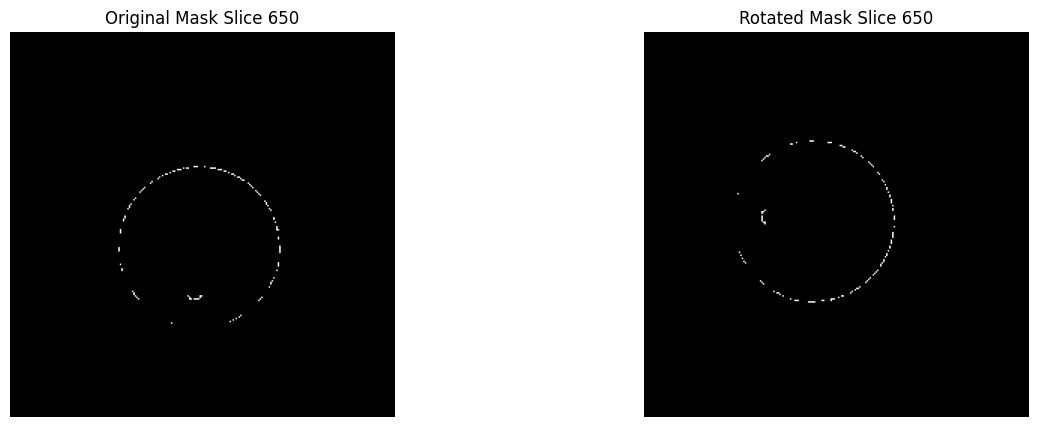

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot a specific slice of the original and processed volumes side by side
def plot_original_and_processed_slice(original_volume, processed_volume, slice_idx=650):
    plt.figure(figsize=(15, 5))
    
    # Plot original volume slice
    plt.subplot(1, 2, 1)
    plt.imshow(original_volume[slice_idx], cmap='gray')
    plt.title(f"Original Mask Slice {slice_idx}")
    plt.axis('off')
    
    # Plot processed volume slice
    plt.subplot(1, 2, 2)
    plt.imshow(processed_volume[slice_idx], cmap='gray')
    plt.title(f"Rotated Mask Slice {slice_idx}")
    plt.axis('off')
    
    plt.show()

# Plot slice 650 of the original and processed volumes side by side
plot_original_and_processed_slice(masks, rotated_masks, slice_idx=650)

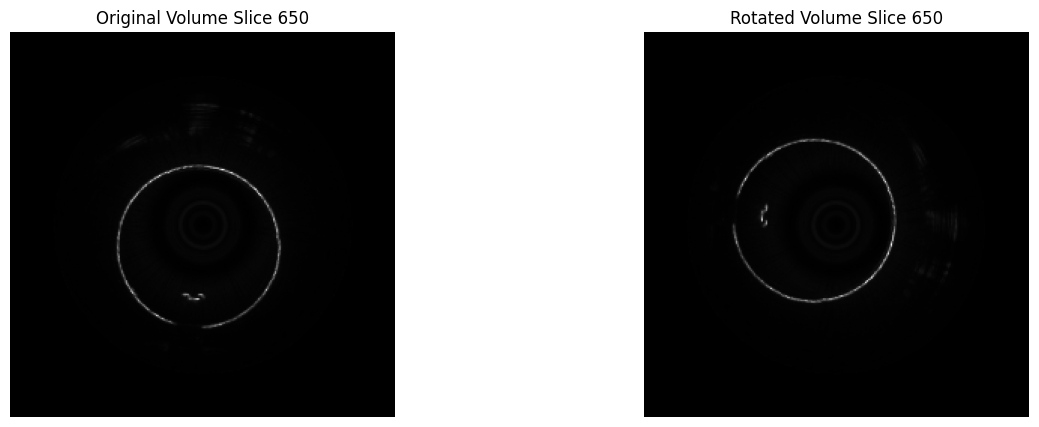

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot a specific slice of the original and processed volumes side by side
def plot_original_and_processed_slice(original_volume, processed_volume, slice_idx=650):
    plt.figure(figsize=(15, 5))
    
    # Plot original volume slice
    plt.subplot(1, 2, 1)
    plt.imshow(original_volume[slice_idx], cmap='gray')
    plt.title(f"Original Volume Slice {slice_idx}")
    plt.axis('off')
    
    # Plot processed volume slice
    plt.subplot(1, 2, 2)
    plt.imshow(processed_volume[slice_idx], cmap='gray')
    plt.title(f"Rotated Volume Slice {slice_idx}")
    plt.axis('off')
    
    plt.show()

# Plot slice 650 of the original and processed volumes side by side
plot_original_and_processed_slice(processed_volume, rotated_processed_volume, slice_idx=650)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ee6345b0-5b50-4d75-aba3-45baad6d02c9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>